## 📓 Hybrid Inversion with SINDBAD-Tutorials

---

### 📌 Purpose

This notebook sets up and runs hybrid inversion experiments using the SINDBAD-Tutorials framework. It includes training of ML-based observation operators and the evaluation of model parameters through data assimilation.

---

### check the system, Mac or Win?

In [1]:
if Sys.iswindows()
    ENV["USER"] = Sys.iswindows() ? ENV["USERNAME"] : ENV["USER"]
end

### ⚙️ Setup & Dependencies

- Uses Julia packages:
  - `SindbadTutorials`, `SindbadML`, `Revise`
  - `Plots` for visualization
- Custom helper functions are imported via `tutorial_helpers.jl`
- User and OS setup is handled for Windows compatibility

---

In [2]:
using Revise
using SindbadTutorials
using SindbadML
using SindbadML.Random
using SindbadTutorials.Plots

include("tutorial_helpers.jl")

selected_site_indices = getSiteIndicesForHybrid();
do_random = 0# set to integer values larger than zero to use random selection of #do_random sites
if do_random > 0
    Random.seed!(1234)
    selected_site_indices = first(shuffle(selected_site_indices), do_random)
end



### Data and Paths
Data to be used can be found here: [Nextcloud Link](https://nextcloud.bgc-jena.mpg.de/s/w2mbH59W4nF3Tcd)  
Organizing the paths of data sources and outputs for this experiment.  
Paths include:
- `path_input`: Zarr data for site-level runs
- `path_observation`: Observation data (in the same file)
- `path_covariates`: Covariates data used in ML training
- `path_output`: Directory for experiment outputs

Two configurations are shown:
1. **Initial Setup**: A simple experiment (commented out to avoid long run time).
2. **WROASTED Setup**: Uses a more complex model setup and runs the full pipeline including:
   - Loading experiment settings JSON
   - Preparing the hybrid inversion environment
   - Training the machine learning model


In [3]:
path_input_dir      = getSindbadDataDepot(; env_data_depot_var="SINDBAD_DATA_DEPOT", 
                    local_data_depot=joinpath(@__DIR__,"..","..","data","ai4pex_2025")); # for convenience, the data file is set within the SINDBAD-Tutorials path; this needs to be changed otherwise.
path_input          = joinpath("$(path_input_dir)","FLUXNET_v2023_12_1D_REPLACED_Noise003_v1.zarr"); # zarr data source containing all the data for site level runs
path_observation    = path_input; # observations (synthetic or otherwise) are included in the same file
path_covariates     = joinpath("$(path_input_dir)","CovariatesFLUXNET_3.zarr"); # zarr data source containing all the covariates
path_output         = "";
path_experiment_json    = joinpath(@__DIR__,"..","ai4pex_2025","settings_LUE","experiment_hybrid.json");
path_training_folds     = "";#joinpath(@__DIR__,"..","ai4pex_2025","settings_WROASTED_HB","nfolds_sites_indices.jld2");

replace_info = Dict(
    "forcing.default_forcing.data_path" => path_input,
    "forcing.subset.site" => selected_site_indices,
    "optimization.observations.default_observation.data_path" => path_observation,
    "optimization.optimization_cost_threaded" => false,
    "optimization.optimization_parameter_scaling" => nothing,
    "hybrid.ml_training.fold_path" => nothing,
    "hybrid.covariates.path" => path_covariates,
);

### generate the info and other helpers
To execute the experiment, helper structures are generated using the JSON settings and associated data paths. These include:
- `info`: the core configuration object (experiment.json, optimization.json, forcing.json) for the experiment
- `forcing`: configurations about meteorological forcing data
- `observations`: synthetic or real measurements of fluxes and states of the terrestrial biosphere model in SINDBAD
- `hybrid_helpers`: encapsulates feature preparation, training, and prediction functions...etc


In [4]:
info            = getExperimentInfo(path_experiment_json; replace_info=deepcopy(replace_info));
forcing         = getForcing(info);
observations    = getObservation(info, forcing.helpers);
sites_forcing   = forcing.data[1].site;
hybrid_helpers  = prepHybrid(forcing, observations, info, info.hybrid.ml_training.method);


┌ Info: getExperimentInfo: load configurations...
└ @ SindbadSetup /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadSetup/src/setupExperimentInfo.jl:24
┌ Info:   readConfiguration:: forcing ::: /Users/xshan/Research/MPI/SINDBAD-Tutorials/tutorials/ai4pex_2025/../ai4pex_2025/settings_LUE/forcing_zarr.json
└ @ SindbadSetup /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadSetup/src/getConfiguration.jl:225
┌ Info:   readConfiguration:: hybrid ::: /Users/xshan/Research/MPI/SINDBAD-Tutorials/tutorials/ai4pex_2025/../ai4pex_2025/settings_LUE/parameter_learning_LUE.json
└ @ SindbadSetup /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadSetup/src/getConfiguration.jl:225
┌ Info:   readConfiguration:: model_structure ::: /Users/xshan/Research/MPI/SINDBAD-Tutorials/tutorials/ai4pex_2025/../ai4pex_2025/settings_LUE/model_structure_LUE.json
└ @ SindbadSetup /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadSetup/src/getConfiguration.jl:225
┌ Info

(train_ratio, val_ratio, test_ratio) = (0.7f0, 0.2f0, 0.1f0)


┌ Info:     Total sites: 184
└ @ SindbadML /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadML/src/prepHybrid.jl:236
┌ Info:     Training sites: 129
└ @ SindbadML /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadML/src/prepHybrid.jl:237
┌ Info:     Validation sites: 37
└ @ SindbadML /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadML/src/prepHybrid.jl:238
┌ Info:     Testing sites: 18
└ @ SindbadML /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadML/src/prepHybrid.jl:239
┌ Info:   Loading Covariates for all from /Users/xshan/Research/MPI/SINDBAD-Tutorials/tutorials/ai4pex_2025/../../data/ai4pex_2025/CovariatesFLUXNET_3.zarr
└ @ SindbadML /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadML/src/prepHybrid.jl:243
┌ Info:     Min/Max of features: [-2.1403506, 9.514583]
└ @ SindbadML /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadML/src/prepHybrid.jl:245
┌ Info:   Building ML model
└ @ SindbadML /Users/xsh

### Train the model
The training of the machine learning model is performed using the `trainML` function:
```julia
trainML(hybrid_helpers, info.hybrid.ml_training.method)
```
This step uses the specified training method and data prepared in the previous steps to fit a parameter estimation model.



In [5]:
trainML(hybrid_helpers, info.hybrid.ml_training.method)


┌ Info:     Epoch 1: training on batch 1 with 32 sites, unscaled_params: minimum=0.45320728, maximum=0.58484536, scaled_params: minimum=0.15857995, maximum=20.09382 | 2025-05-29T19:59:23.886 
└ @ SindbadML /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadML/src/mlTrain.jl:65
┌ Info:     Epoch 1: training on batch 2 with 32 sites, unscaled_params: minimum=0.45838133, maximum=0.5645009, scaled_params: minimum=0.15735959, maximum=19.829 | 2025-05-29T19:59:38.387 
└ @ SindbadML /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadML/src/mlTrain.jl:65
┌ Info:     Epoch 1: training on batch 3 with 32 sites, unscaled_params: minimum=0.44863483, maximum=0.5736518, scaled_params: minimum=0.15682903, maximum=20.31419 | 2025-05-29T19:59:46.057 
└ @ SindbadML /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadML/src/mlTrain.jl:65
┌ Info:     Epoch 1: training on batch 4 with 32 sites, unscaled_params: minimum=0.44830906, maximum=0.55745643, scaled_params: minimu

### Posterior Diagnostics
After training, the model is used to infer site-level parameters from the input features:
```julia
params_sites = ml_model(xfeatures)
```
These inferred parameters are then rescaled to their actual physical ranges using:
```julia
scaled_params_sites = getParamsAct(params_sites, info.optimization.parameter_table)
```
This step provides a site-specific view of parameter values, which can be used for diagnostic evaluation or fed into the forward model for simulation.


In [6]:
# retrieve the inversed parameters
sites_forcing = forcing.data[1].site;
ml_model = hybrid_helpers.ml_model;
xfeatures = hybrid_helpers.features.data;
loss_functions = hybrid_helpers.loss_functions;
loss_component_functions = hybrid_helpers.loss_component_functions;

params_sites = ml_model(xfeatures)
@info "params_sites: [$(minimum(params_sites)), $(maximum(params_sites))]"

scaled_params_sites = getParamsAct(params_sites, info.optimization.parameter_table)
@info "scaled_params_sites: [$(minimum(scaled_params_sites)), $(maximum(scaled_params_sites))]"


┌ Info: params_sites: [0.43908176, 0.5942014]
└ @ Main /Users/xshan/Research/MPI/SINDBAD-Tutorials/tutorials/ai4pex_2025/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X30sZmlsZQ==.jl:9
┌ Info: scaled_params_sites: [0.15804633, 20.26369]
└ @ Main /Users/xshan/Research/MPI/SINDBAD-Tutorials/tutorials/ai4pex_2025/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X30sZmlsZQ==.jl:12


### Site-level Evaluation
To investigate performance at a specific site, one can select a site by index and extract the corresponding inferred parameters. The selected parameters are passed to the site-specific loss function to compute the loss value and its components:


In [7]:
# select a site
# idx = findfirst(x -> x == "DE-Hai", sites_forcing)
site_index = 67
site_name = sites_forcing[site_index]

loc_params = scaled_params_sites(site=site_name).data.data
loss_f_site = loss_functions(site=site_name);
loss_vector_f_site = loss_component_functions(site=site_name);
@time loss_f_site(loc_params)
loss_vector_f_site(loc_params)


  0.141566 seconds (152.65 k allocations: 8.554 MiB, 87.90% compilation time)


(0.5536747f0, Float32[0.5536747], [1])

### Site Simulation with Custom Parameters
The following function is used to run the terrestrial ecosystem model (TEM) for a selected site using either default or optimized parameters:
The function returns the simulated outputs, the loss vector, and the total scalar loss. Example usages include the following codes.
These calls allow for a direct comparison between the default and optimized model runs at the site level.

#### Arguments:
- `selected_models`: A tuple of all models selected in the given model structure.
- `loc_forcing`: A forcing NamedTuple containing the time series of environmental drivers for a single location.
- `loc_spinup_forcing`: A forcing NamedTuple for spinup, used to initialize the model to a steady state (only used if spinup is enabled).
- `loc_forcing_t`: A forcing NamedTuple for a single location and a single time step.
- `loc_output`: An output array or view for storing the model outputs for a single location.
- `loc_land`: Initial SINDBAD land NamedTuple with all fields and subfields.
- `tem_info`: A helper NamedTuple containing necessary objects for model execution and type consistencies.

The function returns the simulated outputs, the loss vector, and the total scalar loss.


In [8]:
# run the model for the site with the default parameters
function run_model_param(info, forcing, observations, site_index, loc_params)
    # info = @set info.helpers.run.land_output_type = PreAllocArrayAll();
    run_helpers = prepTEM(info.models.forward, forcing, observations, info);
    # output all variables
    # info = @set info.output.variables = run_helpers.output_vars;

    params = loc_params;
    selected_models = info.models.forward;
    parameter_scaling_type = info.optimization.run_options.parameter_scaling;
    tbl_params = info.optimization.parameter_table;
    param_to_index = getParameterIndices(selected_models, tbl_params);

    models = updateModels(params, param_to_index, parameter_scaling_type, selected_models);

    loc_forcing = run_helpers.space_forcing[site_index];
    loc_spinup_forcing = run_helpers.space_spinup_forcing[site_index];
    loc_forcing_t = run_helpers.loc_forcing_t;
    loc_output = getCacheFromOutput(run_helpers.space_output[site_index], info.hybrid.ml_gradient.method);
    gradient_lib = info.hybrid.ml_gradient.method;
    loc_output_from_cache = getOutputFromCache(loc_output, params, gradient_lib);
    land_init = deepcopy(run_helpers.loc_land);
    tem_info = run_helpers.tem_info;
    loc_obs = run_helpers.space_observation[site_index];
    loc_cost_option = prepCostOptions(loc_obs, info.optimization.cost_options);
    constraint_method = info.optimization.run_options.multi_constraint_method;
    coreTEM!(
            models,
            loc_forcing,
            loc_spinup_forcing,
            loc_forcing_t,
            loc_output_from_cache,
            land_init,
            tem_info);
    forward_output = (; Pair.(getUniqueVarNames(info.output.variables), loc_output_from_cache)...)
    loss_vector = SindbadTutorials.metricVector(loc_output_from_cache, loc_obs, loc_cost_option);
    t_loss = combineMetric(loss_vector, constraint_method);
    return forward_output, loss_vector, t_loss
end
output_default_site, _, _ = run_model_param(info, forcing, observations, 
                                            site_index, 
                                            info.optimization.parameter_table.default);



# run the model for the site with the parameters from the hybrid 
output_optimized_site, _, _ = run_model_param(info, forcing, observations, 
                                                site_index, 
                                                loc_params);


┌ Info: prepTEM: preparing to run terrestrial ecosystem model (TEM)
└ @ SindbadTEM /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadTEM/src/prepTEM.jl:585
┌ Info:   prepTEMOut: preparing output and helpers...
└ @ SindbadTEM /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadTEM/src/prepTEMOut.jl:372
┌ Info:      preparing spatial and tem helpers
└ @ SindbadTEM /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadTEM/src/prepTEM.jl:403
┌ Info:      model run for one location and time step
└ @ SindbadTEM /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadTEM/src/prepTEM.jl:411
┌ Info:      preallocating local, threaded, and spatial data
└ @ SindbadTEM /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadTEM/src/prepTEM.jl:421
┌ Info: 
│ ----------------------------------------------
└ @ SindbadTEM /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadTEM/src/prepTEM.jl:588
┌ Info: prepTEM: preparing to run terrestrial eco

### Visualization and Summary Statistics
After running the model with both default and optimized parameters, this section compares their performances using time series plots and statistical metrics such as NSE (Nash–Sutcliffe Efficiency). The results are visualized for each site:
- Time series of observed vs. modeled outputs for each variable
- Overlay of default and optimized model outputs
- Evaluation metric (e.g., NSE) shown in the plot legend


plot obs::gpp


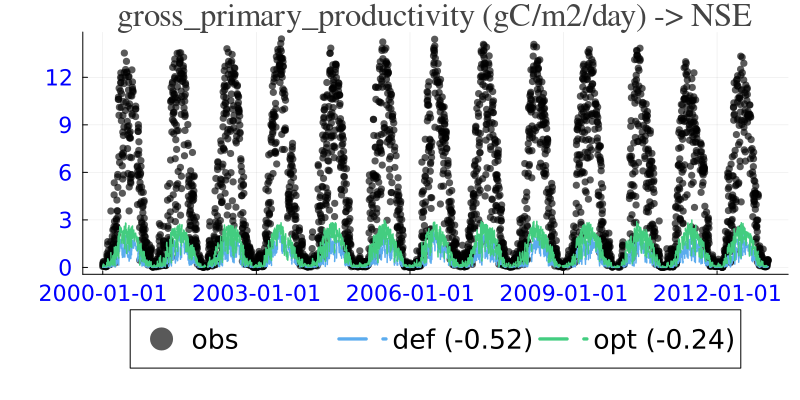

In [12]:

# do plots, compute some simple statistics e.g. NSE
def_dat = output_default_site;
opt_dat = output_optimized_site;
loc_observation = [Array(o[:, site_index]) for o in observations.data];
costOpt = prepCostOptions(loc_observation, info.optimization.cost_options);
default(titlefont=(20, "times"), legendfontsize=18, tickfont=(15, :blue), )
foreach(costOpt) do var_row
    v = var_row.variable
    println("plot obs::", v)
    v = (var_row.mod_field, var_row.mod_subfield)
    vinfo = getVariableInfo(v, info.experiment.basics.temporal_resolution)
    v = vinfo["standard_name"]
    lossMetric = var_row.cost_metric
    loss_name = nameof(typeof(lossMetric))
    if loss_name in (:NNSEInv, :NSEInv)
        lossMetric = NSE()
    end
    (obs_var, obs_σ, def_var) = getData(def_dat, loc_observation, var_row)
    (_, _, opt_var) = getData(opt_dat, loc_observation, var_row)
    obs_var_TMP = obs_var[:, 1, 1, 1]
    non_nan_index = findall(x -> !isnan(x), obs_var_TMP)
    if length(non_nan_index) < 2
        tspan = 1:length(obs_var_TMP)
    else
        tspan = first(non_nan_index):last(non_nan_index)
    end
    obs_σ = obs_σ[tspan]
    obs_var = obs_var[tspan, 1, 1, 1]
    def_var = def_var[tspan, 1, 1, 1]
    opt_var = opt_var[tspan, 1, 1, 1]

    xdata = [info.helpers.dates.range[tspan]...]
    obs_var_n, obs_σ_n, def_var_n = getDataWithoutNaN(obs_var, obs_σ, def_var)
    obs_var_n, obs_σ_n, opt_var_n = getDataWithoutNaN(obs_var, obs_σ, opt_var)
    metr_def = metric(obs_var_n, obs_σ_n, def_var_n, lossMetric)
    metr_opt = metric(obs_var_n, obs_σ_n, opt_var_n, lossMetric)
    p1 = plot(xdata, obs_var; label="obs", seriestype=:scatter, mc=:black, ms=4, lw=0, ma=0.65, left_margin=1Plots.cm)
    plot!(xdata, def_var, color=:steelblue2, lw=1.5, ls=:dash, left_margin=1Plots.cm, legend=:outerbottom, 
        legendcolumns=3, label="def ($(round(metr_def, digits=2)))", size=(800, 400), 
        title="$(vinfo["long_name"]) ($(vinfo["units"])) -> $(nameof(typeof(lossMetric)))")
    plot!(xdata, opt_var; color=:seagreen3, label="opt ($(round(metr_opt, digits=2)))", lw=1.5, ls=:dash)
    display(p1)
    savefig(joinpath(info.output.dirs.figure, "wroasted_$(site_name)_$(v).png"))
end


Additionally, for all sites, the scalar loss values (e.g., inverse NSE) are computed and stored. These are then visualized using a histogram to assess the distribution of performance across the full site ensemble:


┌ Info: 1
└ @ Main /Users/xshan/Research/MPI/SINDBAD-Tutorials/tutorials/ai4pex_2025/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X45sZmlsZQ==.jl:11
┌ Info: AR-SLu
└ @ Main /Users/xshan/Research/MPI/SINDBAD-Tutorials/tutorials/ai4pex_2025/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X45sZmlsZQ==.jl:12
┌ Info: running using default parameters...
└ @ Main /Users/xshan/Research/MPI/SINDBAD-Tutorials/tutorials/ai4pex_2025/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X45sZmlsZQ==.jl:13
┌ Info: prepTEM: preparing to run terrestrial ecosystem model (TEM)
└ @ SindbadTEM /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadTEM/src/prepTEM.jl:585
┌ Info:   prepTEMOut: preparing output and helpers...
└ @ SindbadTEM /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadTEM/src/prepTEMOut.jl:372
┌ Info:      preparing spatial and tem helpers
└ @ SindbadTEM /Users/xshan/Research/MPI/SINDBAD-Tutorials/SINDBAD/lib/SindbadTEM/src/prepTEM.jl:403
┌ Info:      model run f

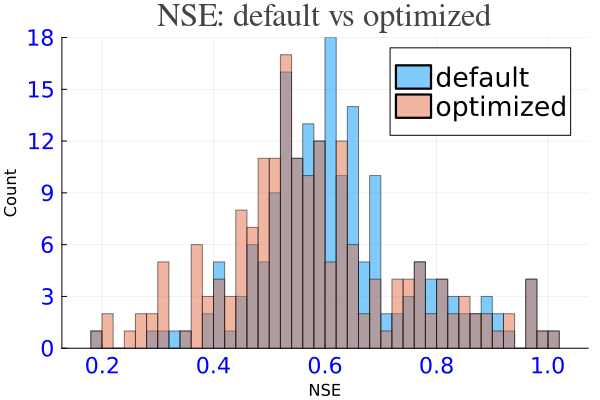

"/Users/xshan/Research/MPI/SINDBAD-Tutorials/tutorials/ai4pex_2025/output_FLUXNET_LUE/figure/loss_histogram_scalar.png"

In [13]:

# preallocate
n_sites = length(sites_forcing);
t_loss_def = Vector{Float32}(undef, n_sites);
t_loss_opt = Vector{Float32}(undef, n_sites);

# for (i, site_index) in enumerate(1:n_sites)
# i = 1
# for site_index in hybrid_helpers.indices.testing
for (i, site_index) in enumerate(1:n_sites)
    @info site_index
    @info sites_forcing[site_index]
    @info "running using default parameters..."
    # # the following way could be faster to run...
    # loss_f_site = loss_functions(site=site_name);
    # loss_vector_f_site = loss_component_functions(site=site_name);
    # loss_f_site(loc_params)
    # loss_vector_f_site(loc_params)

    # run default
    _, lv_def, tl_def = run_model_param(
       info, forcing, observations, site_index,
       info.optimization.parameter_table.default
    )
    # run optimized
    @info "running using optimized parameters..."
    _, lv_opt, tl_opt = run_model_param(
       info, forcing, observations, site_index,
       scaled_params_sites(site=sites_forcing[site_index]).data.data
    )
    # collect
    t_loss_def[i]     = tl_def
    t_loss_opt[i]     = tl_opt
    # i += 1
end

# now plot histogram of scalar losses
h1 = histogram(
  t_loss_def,
  bins = 50,
  alpha = 0.5,
  label = "default",
  xlabel = "NSE",
  ylabel = "Count",
  title = "NSE: default vs optimized"
)
histogram!(
  t_loss_opt,
  bins = 50,
  alpha = 0.5,
  label = "optimized"
)
display(h1)
savefig(joinpath(info.output.dirs.figure, "loss_histogram_scalar.png"))


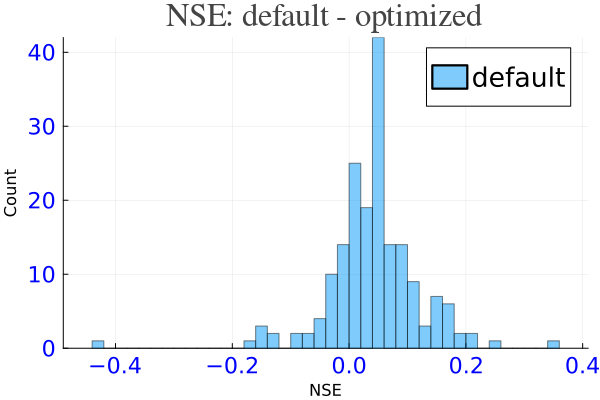

"/Users/xshan/Research/MPI/SINDBAD-Tutorials/tutorials/ai4pex_2025/output_FLUXNET_LUE/figure/loss_diff_histogram_scalar.png"

In [14]:
# now plot histogram of scalar losses
h2 = histogram(
  t_loss_def .- t_loss_opt,
  bins = 50,
  alpha = 0.5,
  label = "default",
  xlabel = "NSE",
  ylabel = "Count",
  title = "NSE: default - optimized"
)
# histogram!(
#   t_loss_opt,
#   bins = 50,
#   alpha = 0.5,
#   label = "optimized"
# )
display(h2)
savefig(joinpath(info.output.dirs.figure, "loss_diff_histogram_scalar.png"))

In [ ]:
hybrid_helpers